# Multiscale Graph Correlation (MGC)

In this tutorial, we explore

- The theory behind the MGC test statistic and p-value
- The features of the implementation
- A fast implementation of MGC

## Theory

The following description is adapted from [[1]](https://arxiv.org/abs/1907.02088):

MGC is a  generalization of distance covariance (Dcov) that preserves the consistency property while achieving better power in many typical multivariate non-monotonic settings, which also providing some characterization of the latent geometry of the relationship [[2]](https://elifesciences.org/articles/41690). It is performed utilizing the following steps:

1. Two distance matrices ${\mathbf{D}}^{\mathbf{x}}$ and ${\mathbf{D}}^{\mathbf{y}}$ are computed, and modified to be mean zero column-wise. This results in two $n \times n$ distance matrices ${\mathbf{C}}^{\mathbf{x}}$ and ${\mathbf{C}}^{\mathbf{y}}$.


2. For all values $k$ and $l$ from $1, ..., n$,

    a. The $k$-nearest neighbor and $l$-nearest neighbor graphs are calculated for each property. Here, $\mathbf{G}_k (i, j)$ indicates the $k$ smallest values of the $i$-th row of ${\mathbf{D}}^{\mathbf{x}}$ and $\mathbf{H}_l (i, j)$ indicates the $l$ smallest values of the $i$-th row of ${\mathbf{D}}^{\mathbf{y}}$.

    b. Let $\circ$ denotes the entry-wise matrix product, then local correlations are summed and normalized using the following statistic:

$$ c^{kl} = \frac{\mathrm{tr}{( {\mathbf{C}}^{\mathbf{x}} \circ \mathbf{G}_k) ({\mathbf{C}}^{\mathbf{y}} \circ \mathbf{H}_l)^{T}}}{\sqrt{\mathrm{tr}{ ({\mathbf{C}}^{\mathbf{x}} \circ \mathbf{G}_k) ({\mathbf{C}}^{\mathbf{y}} \circ \mathbf{H}_l)^{T}}\mathrm{tr}{ ({\mathbf{C}}^{\mathbf{x}} \circ \mathbf{G}_k) ({\mathbf{C}}^{\mathbf{y}} \circ \mathbf{H}_l}^{T})}},$$


3. The MGC test statistic is the smoothed optimal local correlation of $\left\{ c^{kl} \right\}$. Denote the smoothing operation as $R(\cdot)$ (which essentially set all isolated large correlations as $0$ and connected large correlations same as before), MGC is

$$ \mathrm{MGC}_n (\mathbf{x}, \mathbf{y}) = \max_{(k, l)} R(c^{kl} (\mathbf{x}_n, \mathbf{y}_n)).$$

The p-value is then calculated using a standard permutation test. The smoothed correlations are also used to produce the MGC-map and optimal scale, which can enable further analysis of the relationship between the inputs.

## Using MGC

### Test statistic and p-value

Before delving straight into function calls, let's first import some useful functions, to ensure consistency in these examples, we set the seed:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('classic')
import matplotlib.ticker as ticker
import seaborn as sns; sns.set(style="white")

from mgcpy.independence_tests.mgc import MGC
from mgcpy.benchmarks import simulations as sims

np.random.seed(12345678)

To start, let's simulate some linear data:

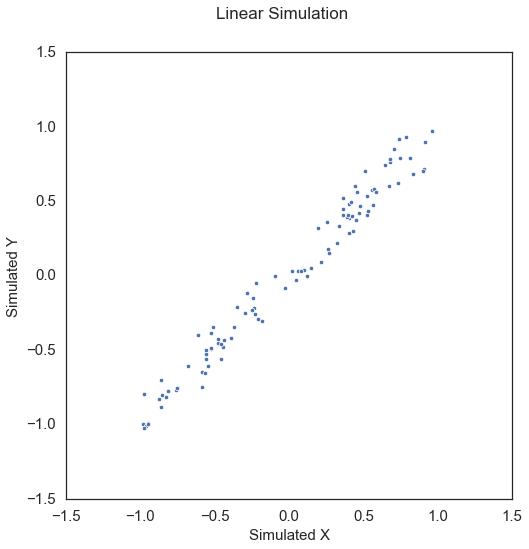

In [2]:
x, y = sims.linear_sim(num_samp=100, num_dim=1, noise=0.1)

fig = plt.figure(figsize=(8,8))
fig.suptitle("Linear Simulation", fontsize=17)
ax = sns.scatterplot(x=x[:,0], y=y[:,0])
ax.set_xlabel('Simulated X', fontsize=15)
ax.set_ylabel('Simulated Y', fontsize=15) 
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

The test statistic and p-value can be called by creating the `MGC` object and simply calling the corresponding test statistic and p-value methods.

In [3]:
mgc = MGC()
mgc_statistic, independence_test_metadata = mgc.test_statistic(x, y)
p_value, _ = mgc.p_value(x, y)

print("MGC test statistic:", mgc_statistic)
print("P Value:", p_value)

MGC test statistic: 0.9719961704553086
P Value: 0.001


Based on this relationship, we would expect MGC to have a test statistic of approximately 1 [[2]](https://elifesciences.org/articles/41690) and a p-value bounded by the number of repetitions (in this case 1000). This is because since we are estimating the null distribution via permutation, this is the lowest value that we can be sufficiently sure is the p-value. It is worth noting that as in most of the other tests that use permutation to approximate the p-value, the `replication_factor` parameter can be set to the desired number.

### MGC-map and optimal scale

Unlike many other independence tests, MGC also includes many other features (collectively included in the metadata) to enable users to discover and decipher their relationships. Two particularly useful features are the optimal scale and the map of the localized variances, also known as the MGC-map, which can reveal a representation of the underlying geometry of the relationship. These are both returned in both the `test_statistic` and `p_value` methods in the `metadata` return value. Taking the same relationship as before, let's investigate what that would actually look like.

Optimal Scale: [100, 100]


/Users/spanda/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


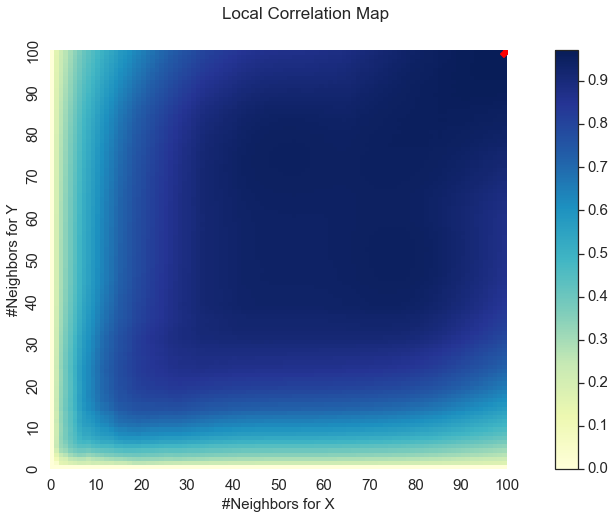

In [4]:
print("Optimal Scale:", independence_test_metadata["optimal_scale"])

# local correlation map
local_corr = independence_test_metadata["local_correlation_matrix"]

# define two rows for subplots
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap
fig.suptitle("Local Correlation Map", fontsize=17)
ax = sns.heatmap(local_corr, cmap="YlGnBu", ax=ax, cbar=False)

# colorbar
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
optimal_scale = independence_test_metadata["optimal_scale"]
ax.scatter(optimal_scale[0], optimal_scale[1], marker='X', s=200, color='red') 

# other formatting
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('#Neighbors for X', fontsize=15)
ax.set_ylabel('#Neighbors for Y', fontsize=15) 
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cax.xaxis.set_tick_params(labelsize=15)
cax.yaxis.set_tick_params(labelsize=15)
# fig.suptitle('cMGC = ' + str(mgc_statistic) + ', pMGC = ' + str(p_value), fontsize=20)

plt.show()

Here, we see a representation of the relationship between $x$ and $y$ plotted as a heat map and the optimal scale shown in the top right corner represented as a red "x". The optimal scale is the $k$ and $l$ nearest neighbors that maximize the smoothed local correlations of the test statistic; in other words, maximizes the test statistic. For a linear relationship like this one, the optimal scale is equivalent to the global scale, which is $(n, n)$.

Interestingly the MGC-map is unique for every type of relationship [[2]](https://elifesciences.org/articles/41690). Let's see how this changes with a nonlinear relationship. First, we will simulated some nonlinear data:

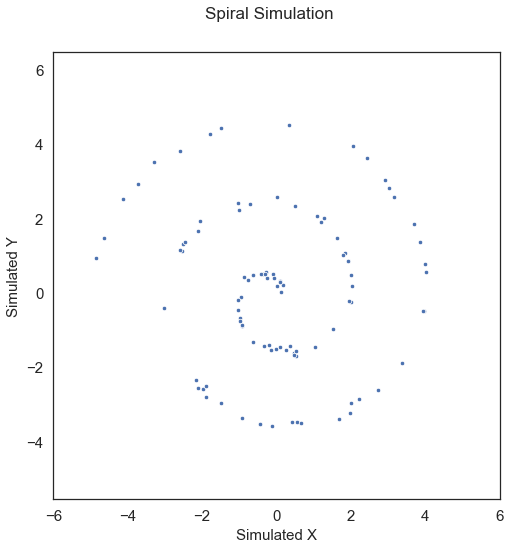

In [5]:
x, y = sims.spiral_sim(num_samp=100, num_dim=1, noise=0.1)

fig = plt.figure(figsize=(8,8))
fig.suptitle("Spiral Simulation", fontsize=17)
ax = sns.scatterplot(x=x[:,0], y=y[:,0])
ax.set_xlabel('Simulated X', fontsize=15)
ax.set_ylabel('Simulated Y', fontsize=15) 
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

MGC is able to capture this relationship as well. Running MGC, we get the following test statistic and p-value:

In [6]:
mgc = MGC()
mgc_statistic, independence_test_metadata = mgc.test_statistic(x, y)
p_value, _ = mgc.p_value(x, y)

print("MGC test statistic:", mgc_statistic)
print("P Value:", p_value)

MGC test statistic: 0.1769756923534378
P Value: 0.001


Here we get a p-value less than the alpha level of 0.05 that we are testing at. Looking at the optimal scale and MGC-map, something interesting occurs:

Optimal Scale: [7, 6]


/Users/spanda/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


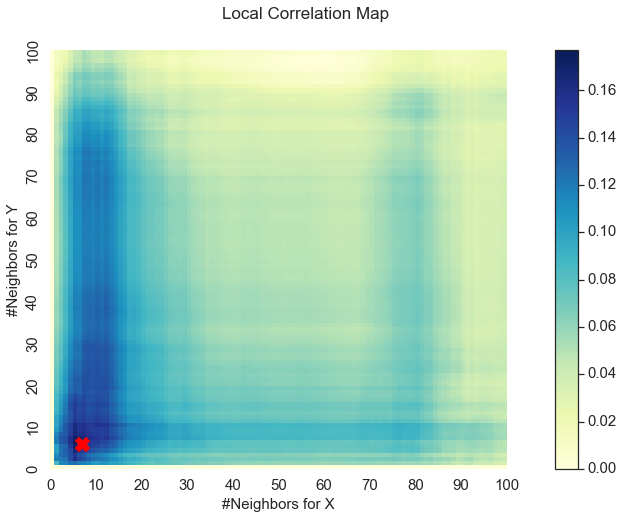

In [7]:
print("Optimal Scale:", independence_test_metadata["optimal_scale"])

# local correlation map
local_corr = independence_test_metadata["local_correlation_matrix"]

# define two rows for subplots
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap
fig.suptitle("Local Correlation Map", fontsize=17)
ax = sns.heatmap(local_corr, cmap="YlGnBu", ax=ax, cbar=False)

# colorbar
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
optimal_scale = independence_test_metadata["optimal_scale"]
ax.scatter(optimal_scale[0], optimal_scale[1], marker='X', s=200, color='red') 

# other formatting
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('#Neighbors for X', fontsize=15)
ax.set_ylabel('#Neighbors for Y', fontsize=15) 
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cax.xaxis.set_tick_params(labelsize=15)
cax.yaxis.set_tick_params(labelsize=15)
# fig.suptitle('cMGC = ' + str(mgc_statistic) + ', pMGC = ' + str(p_value), fontsize=20)

plt.show()

We get a unique MGC-map and the optimal scale has shifted! This is because for nonlinear relationships like this one, smaller $k$ and $l$ nearest neighbors more strongly define the relationship. As such, MGC sets the optimal scale to be local rather than global from before.

## A faster version of MGC (Fast MGC)

Thus far, we have shown that MGC is an powerful tool that is able to determine trends in linear and nonlinear relationship data sets. Unfortunately, it suffers from one problem: performance. MGC operates in $\mathcal{O} (n^2 \log n)$ time. To alleviate these problems Fast MGC can be used. This version of MGC takes bootstrapped subsamples of the input data matrices and estimates the null distribution using the subsamples. Fast MGC, thus, operates in $\mathcal{O} (n \log n)$ time.

Calling Fast MGC is similar to calling MGC except that the `is_fast` flag should be set to `True` in either the `test_statistic` or `p_value` methods. The number of subsamples used can either be defined or can be chosen optimally from the provided data. Using the same nonlinear data as before,

In [8]:
x, y = sims.spiral_sim(num_samp=1000, num_dim=1, noise=0.1)

mgc = MGC()

fast_mgc_data={"sub_samples": 10} # custom number of sub_samples set, optimal parameter
fast_mgc_statistic, test_statistic_metadata = mgc.test_statistic(x, y, is_fast=True, fast_mgc_data=fast_mgc_data)
fast_mgc_p_value, _ = mgc.p_value(x, y, is_fast=True, fast_mgc_data=fast_mgc_data)

# print the results
print("FastMGC test statistic:", fast_mgc_statistic)
print("P Value:", fast_mgc_p_value)
print("Optimal Scale:", test_statistic_metadata["optimal_scale"])

FastMGC test statistic: 0.14386065297425885
P Value: 0.001
Optimal Scale: [39, 47]


This is able to calculate many more samples in a time faster than MGC!